# 정맥 이미지 촬영 시스템 GUI

In [32]:
from tkinter import *
from PIL import ImageTk, Image # Pillow
import cv2
import os
import datetime
import numpy as np

# GUI 설계
win = Tk() # 인스턴스 생성

win.title("손 정맥 스캐너") # 제목 표시줄 추가
win.option_add("*Font", "맑은고딕 25") # 전체 폰트

#win.resizable(False, False) # x축, y축 크기 조정 비활성화

# 라벨 추가
lbl = Label(win, text="손 정맥 스캐너")
lbl.grid(row=0, column=0) # 라벨 행, 열 배치

# 프레임 추가
frm = Frame(win, bg="white", width=720, height=480) # 프레임 너비, 높이 설정
frm.grid(row=1, column=0) # 격자 행, 열 배치

# 라벨 추가
lbl1 = Label(frm)
lbl1.grid()

cap = cv2.VideoCapture(1) # VideoCapture 객체 정의

def video_play():
   ret, frame = cap.read()
   frame = cv2.flip(frame, 1) # 상하반전
   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

   img = Image.fromarray(frame)
   imgtk = ImageTk.PhotoImage(image=img)

   lbl1.imgtk = imgtk
   lbl1.configure(image=imgtk)
   lbl1.after(10, video_play)

video_play()

# 버튼 추가
btn = Button(win, text = "촬영") # 버튼 생성
btn.grid(row=2, column=0) # 라벨 행, 열 배치
btn.config(width = 5, height = 1) # 버튼 크기

def alert():

   ret, frame = cap.read()
   frame = cv2.flip(frame, 1) # Flip camera vertically
   
   # 컬러 이미지 저장
   vein_img = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_ORGINAL") + '.jpg'
   cv2.imwrite(vein_img, frame)
   
   # 컬러 이미지 불러오기 및 이미지 자르기 및 이미지 저장
   img = cv2.imread(vein_img)

   img = img[110:350, 165:450].copy()
   img1 = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_CROPPING") + '.jpg'
   cv2.imwrite(img1, img)
   
   ####### 이미지 처리 #######
   # noise
   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   noise = cv2.fastNlMeansDenoising(gray)
   noise = cv2.cvtColor(noise, cv2.COLOR_GRAY2BGR)

   # equalist hist
   kernel = np.ones((7,7),np.uint8)
   img = cv2.morphologyEx(noise, cv2.MORPH_OPEN, kernel)
   img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
   img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
   img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

   # invert
   inv = cv2.bitwise_not(img_output)

   # erode
   gray = cv2.cvtColor(inv, cv2.COLOR_BGR2GRAY)
   erosion = cv2.erode(gray,kernel,iterations = 1)
    
   # skel
   img = gray.copy()
   skel = img.copy()
   skel[:,:] = 0
   kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
   iterations = 0

   while True:
       eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
       temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
       temp  = cv2.subtract(img, temp)
       skel = cv2.bitwise_or(skel, temp)
       img[:,:] = eroded[:,:]
       if cv2.countNonZero(img) == 0:
           break

   ret, thr = cv2.threshold(skel, 5,255, cv2.THRESH_BINARY);

   ####### 이미지 처리 #######

   cv2.imwrite("result.jpg", thr) # 이미지 처리 된 이미지 저장

btn.config(command = alert) # 버튼 기능

win.mainloop() #GUI 시작

# 손 정맥 스캐너 GUI

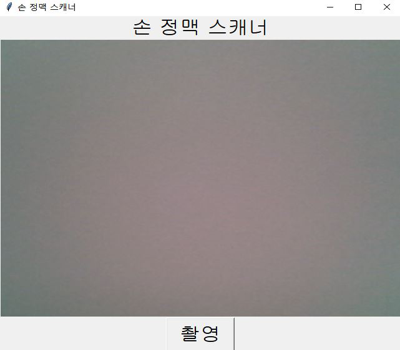

In [31]:
image0 = Image.open("images\\GUI.jpg")
image0 = image0.resize((400, 350))
image0

# 원본 사진

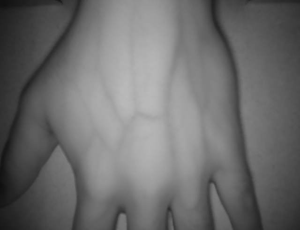

In [22]:
image1 = Image.open("images\\20210511_184923_ORIGINAL.jpg")
image1 = image1.resize((300, 230))
image1

# 이미지 자르기

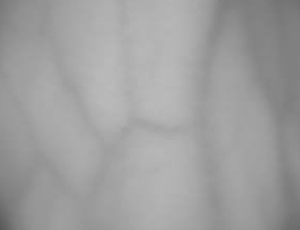

In [23]:
image2 = Image.open("images\\20210511_184923_CROPPING.jpg")
image2 = image2.resize((300, 230))
image2

# 이미지 처리한 결과

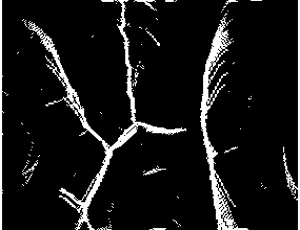

In [24]:
image3 = Image.open("images\\result.jpg")
image3 = image3.resize((300, 230))
image3